In [1]:
import os
from typing import Dict, List
import math
import torch
import pyro
import pyro.distributions as dist
from ts_plots import plot_ts
import pyro.optim as optim
import pyro.infer as infer
import seaborn as sns   
import matplotlib.pyplot as plt
import pyro
import torch
from chirho.indexed.ops import IndexSet, gather, indices_of
from pyro.infer.autoguide import (AutoMultivariateNormal, init_to_mean, AutoNormal,
                                   AutoLowRankMultivariateNormal,  AutoGaussian,)
import copy

# import condition from chirho
from chirho.observational.handlers import condition


from torch.utils.data import DataLoader



smoke_test = 'CI' in os.environ

n_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 500
n_series = 2 if smoke_test else 8 #TODO upgarde to 5

In [2]:
census_tracts_data_path = "pg_census_tracts_dataset.pt"

def select_from_data(data, kwarg_names: Dict[str, List[str]]):
    _data = {}
    _data["outcome"] = data["continuous"][kwarg_names["outcome"]]
    _data["categorical"] = {
        key: val
        for key, val in data["categorical"].items()
        if key in kwarg_names["categorical"]
    }
    _data["continuous"] = {
        key: val
        for key, val in data["continuous"].items()
        if key in kwarg_names["continuous"]
    }

    return _data

ct_dataset_read = torch.load(census_tracts_data_path, weights_only=False)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract", 'university_index', 'downtown_index'],
    "continuous": {
        "housing_units",
        "housing_units_original"
        "total_value",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        'limit',
        "segregation_original",
        "white_original",
        "parcel_sqm",
        'downtown_overlap', 
        'university_overlap',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

In [38]:
outcome_obs = copy.deepcopy(subset['outcome'])

series_idx = copy.deepcopy(subset['categorical']['census_tract'])
time_idx = copy.deepcopy(subset['categorical']['year'])


unique_series = torch.unique(series_idx)
unique_times = torch.unique(time_idx)

num_series = unique_series.size(0)
time_steps = unique_times.size(0)

reshaped_outcome = torch.empty((num_series, time_steps), dtype=outcome_obs.dtype)
reshaped_outcome[...,:] = torch.nan 

def reshape_into_time_series(variable, series_idx, time_idx):
    
    # raise value eror if they are not of the same shape
    if variable.shape[0] != series_idx.shape[0] or variable.shape[0] != time_idx.shape[0]:
        raise ValueError("The shapes of variable, series_idx, and time_idx must match.")
    
    unique_series = torch.unique(series_idx)
    unique_times = torch.unique(time_idx)

    num_series = unique_series.size(0)
    time_steps = unique_times.size(0)

    reshaped_variable= torch.empty((num_series, time_steps), dtype=variable.dtype)
    reshaped_variable[...,:] = torch.nan

    for i, series in enumerate(unique_series):
        for j, time in enumerate(unique_times):
            mask = (series_idx == series) & (time_idx == time)
            index = torch.where(mask)[0]
            if index.numel() > 0:
                reshaped_variable[i, j] = variable[index]
    
    for i, series_id in enumerate(unique_series):
        sorted_times, sorted_indices = torch.sort(time_idx[series_idx == series_id])
        sorted_outcomes = outcome_obs[series_idx == series_id][sorted_indices]
        assert torch.all(reshaped_variable[i,:] == sorted_outcomes)

    return { "reshaped_variable": reshaped_variable, "unique_series": unique_series, "unique_times": unique_times }

reshaped_outcome_obs = reshape_into_time_series(outcome_obs, series_idx, time_idx) 
outcome_obs_ts = reshaped_outcome_obs["reshaped_variable"]


In [33]:
print(unique_series)
print(series_position.shape)

tensor([27053000101, 27053000102, 27053000300, 27053000601, 27053000603,
        27053001100, 27053001700, 27053002200, 27053002400, 27053002700,
        27053003200, 27053003300, 27053003800, 27053005901, 27053005902,
        27053006800, 27053007700, 27053007801, 27053008100, 27053008200,
        27053008300, 27053008400, 27053008500, 27053009500, 27053009600,
        27053010600, 27053010700, 27053011000, 27053011703, 27053011800,
        27053011998, 27053012001, 27053012003, 27053100200, 27053100400,
        27053100500, 27053100700, 27053100800, 27053100900, 27053101200,
        27053101300, 27053101600, 27053101800, 27053101900, 27053102000,
        27053102100, 27053102300, 27053102500, 27053102600, 27053102800,
        27053102900, 27053103000, 27053103100, 27053103400, 27053103600,
        27053103700, 27053103900, 27053104000, 27053104100, 27053104400,
        27053104800, 27053104900, 27053105100, 27053105201, 27053105204,
        27053105400, 27053105500, 27053105600, 2705

In [30]:
print(outcome_obs[series_idx == 27053102800])

series_idx

tensor([-0.3007, -0.3340, -0.3229, -0.3007, -0.3340, -0.3007, -0.3229, -0.3451,
        -0.3007, -0.3340])


tensor([27053102800, 27053105600, 27053102000,  ..., 27053108600,
        27053100200, 27053100700])

torch.Size([8, 1])
predictor tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000,
         -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000,
         -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000,
         -2.0000, -2.0000],
        [ 1.1000,  1.1000,  1.1000,  1.1000,  1.1000,  1.1000,  1.1000,  1.1000,
          1.1000,  1.1000,  1.1000,  1.1000,  1.1000,  1.1000,  1.1000,  1.1000,
          1.1000,  1.1000,  1.1000,  1.1000,  1.1000,  1.1000,  1.1000,  1.1000,
          1.1000, -1.8000, -1.8000, -1.8000, -1.8000, -1.8000, -1.8000, -1.8000,
         -1.8000, -1.8000, -1.8000, -1.8000, -1.8000, -1.8000, -1.8000, -1.8000,
         -1.8000, -1.8000, -1.8000, -1.8000, -1.8000

/tmp/ipykernel_259967/3164560226.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


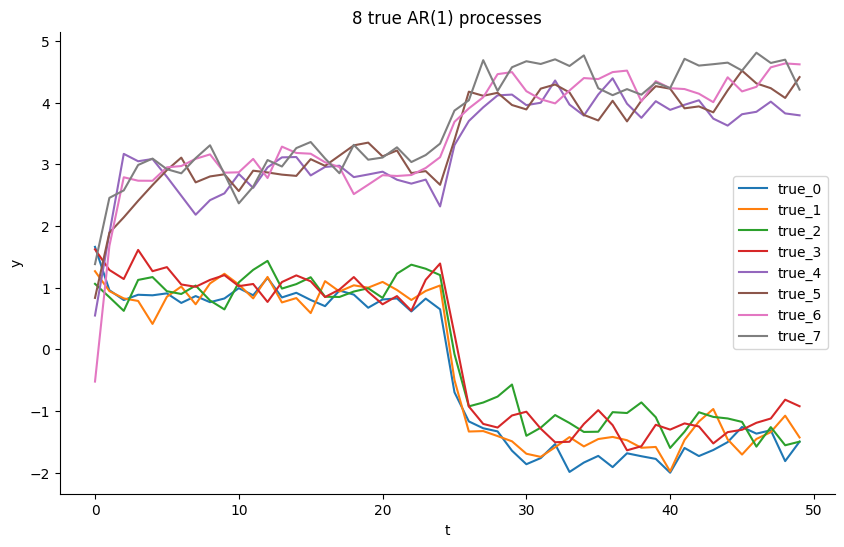

In [2]:
# true ar1 process
T = 50
n_series = n_series

true_phi = .4
true_sigma = .2

true_contribution = 0.5

 # 2D tensor of shape (n_series, 1) with random values
 #set seed
torch.manual_seed(1)

with pyro.plate("series", n_series, dim  = -2):
    init = pyro.sample("init", dist.Normal(1, 1))
 
mid = T//2

predictor = torch.zeros((n_series,T))
for i in range(n_series//2):
    predictor[i,:mid] = 1. + i/10
    predictor[i, mid:] = -2. + 2*i/10

for i in range(n_series//2, n_series):
    predictor[i,:mid] = 3. + i/10
    predictor[i, mid:] = 4. + 2*i/10


print("predictor", predictor)

print("init", init, init.shape)
y_true = torch.zeros((n_series,T))
y_exp_true = torch.zeros( (n_series,T))
y_prev_true = torch.zeros((n_series,T))


y_exp_true[:,0] = true_contribution * predictor[:,0]
print("ytrue", y_true[:,0], y_true[:,0].shape)
print("init", init, init.shape)
y_true[:,0] = init.squeeze()


for t in range(1, T):
    
    y_prev_true[:,t] = y_true[:,t-1]
    y_exp_true[:,t] = true_phi * y_prev_true[...,:,t] + true_contribution * predictor[...,:,t] 
    
    y_true[:,t] = pyro.sample(f"y_{t}", dist.Normal(y_exp_true[:,t], true_sigma))
    print("sampling", y_exp_true[:,t], y_true[:,t], true_sigma)
   

fig, ax= plot_ts(y_true, title=f"{n_series} true AR(1) processes", xlabel="t", ylabel="y",)
fig.show()


In [13]:
class AR1model(pyro.nn.PyroModule):
    def __init__(self):
        super().__init__()

    def forward(self, outcome_obs = None, predictor_obs = None,
                 initial_obs = None, T = None, no_series = n_series):

        if outcome_obs is not None:
            T = outcome_obs.shape[-1]


        phi = pyro.sample("phi", dist.Normal(1., 0.4))  
        sigma = pyro.sample("sigma", dist.Uniform(0.001, 1.0))
        

        contribution = pyro.sample("contribution", dist.Normal(0.02, 1.))

        series_plate = pyro.plate("series", no_series, dim = -2)

        time_plate = pyro.plate("time", T, dim=-1)

        with series_plate:
            
            with time_plate:
                predictor = pyro.sample( "predictor", dist.Normal(0.0, 1.0), obs=predictor_obs)

       
        y_ts = {}
        y_exp = {}
        y_prev = {}

        
        y_prev[0] = torch.zeros_like(predictor[...,:,0].unsqueeze(-1))


        with series_plate:

            y_exp[0] = contribution * predictor[...,:,0].unsqueeze(-1)
            
            y_ts[0]= pyro.sample("y_0", dist.Normal(y_exp[0], sigma),  obs=initial_obs)


        for t in range(1, T):
            
            with series_plate:
                y_prev[t] = y_ts[t-1]
                pred_slice = predictor[...,:,t].unsqueeze(-1)
                y_exp[t] = pyro.deterministic(f"y_exp_{t}", phi * y_prev[t] + contribution * pred_slice)
             
                y_ts[t] = pyro.sample(f"y_{t}", dist.Normal(y_exp[t], sigma), 
                             obs=outcome_obs[:,t].unsqueeze(-1) if outcome_obs is not None else None)
            
        y_ts_stacked = pyro.deterministic("y_stacked", torch.cat(list(y_ts.values()), dim=1))
    
        return y_ts, y_ts_stacked

ar1_model = AR1model()

print(init)

with condition(data = {"phi": true_phi, "sigma": true_sigma, "contribution": true_contribution}):
    with pyro.poutine.trace() as tr:
        _, y_intermediate  = ar1_model(outcome_obs=None, initial_obs=init, 
                                  predictor_obs=predictor, T=T, no_series=n_series)

tensor([[ 1.6614],
        [ 1.2669],
        [ 1.0617],
        [ 1.6213],
        [ 0.5481],
        [ 0.8339],
        [-0.5228],
        [ 1.3817]])


odict_keys(['phi', 'sigma', 'contribution', 'series', 'time', 'init', 'predictor', 'y_0', 'y_exp_1', 'y_1', 'y_exp_2', 'y_2', 'y_exp_3', 'y_3', 'y_exp_4', 'y_4', 'y_exp_5', 'y_5', 'y_exp_6', 'y_6', 'y_exp_7', 'y_7', 'y_exp_8', 'y_8', 'y_exp_9', 'y_9', 'y_exp_10', 'y_10', 'y_exp_11', 'y_11', 'y_exp_12', 'y_12', 'y_exp_13', 'y_13', 'y_exp_14', 'y_14', 'y_exp_15', 'y_15', 'y_exp_16', 'y_16', 'y_exp_17', 'y_17', 'y_exp_18', 'y_18', 'y_exp_19', 'y_19', 'y_exp_20', 'y_20', 'y_exp_21', 'y_21', 'y_exp_22', 'y_22', 'y_exp_23', 'y_23', 'y_exp_24', 'y_24', 'y_exp_25', 'y_25', 'y_exp_26', 'y_26', 'y_exp_27', 'y_27', 'y_exp_28', 'y_28', 'y_exp_29', 'y_29', 'y_exp_30', 'y_30', 'y_exp_31', 'y_31', 'y_exp_32', 'y_32', 'y_exp_33', 'y_33', 'y_exp_34', 'y_34', 'y_exp_35', 'y_35', 'y_exp_36', 'y_36', 'y_exp_37', 'y_37', 'y_exp_38', 'y_38', 'y_exp_39', 'y_39', 'y_exp_40', 'y_40', 'y_exp_41', 'y_41', 'y_exp_42', 'y_42', 'y_exp_43', 'y_43', 'y_exp_44', 'y_44', 'y_exp_45', 'y_45', 'y_exp_46', 'y_46', 'y_exp_4

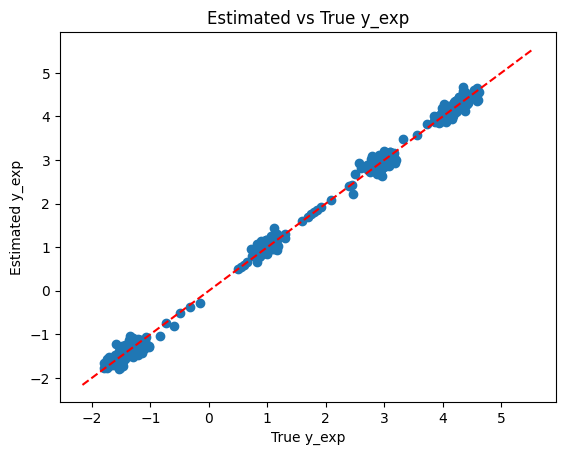

In [4]:
print(tr.trace.nodes.keys())

assert tr.trace.nodes['phi']['value']==  true_phi
assert tr.trace.nodes['sigma']['value']== true_sigma
assert tr.trace.nodes['contribution']['value']== true_contribution
assert torch.equal(tr.trace.nodes['predictor']['value'], predictor)   


max_graph = 1.2 * torch.max(y_exp_true)
min_graph = 1.2 * torch.min(y_exp_true)
plt.scatter( y_exp_true.flatten(), tr.trace.nodes["y_exp_stacked"]['value'].flatten())
plt.plot([min_graph, max_graph], [min_graph, max_graph], linestyle='--', color='red')

plt.xlabel("True y_exp")
plt.ylabel("Estimated y_exp")
plt.title("Estimated vs True y_exp")
plt.show()

assert torch.allclose(y_intermediate, y_true, atol= true_sigma * 8)

torch.Size([8, 50]) torch.Size([8, 50]) torch.Size([8, 1])
[iteration 0001] loss: 2812.8303
[iteration 0100] loss: 2630.1743
[iteration 0200] loss: 2557.0708
[iteration 0300] loss: 2576.9009
[iteration 0400] loss: 2599.6711
[iteration 0500] loss: 2560.7441
[iteration 0600] loss: 2564.7576
[iteration 0700] loss: 2572.7246
[iteration 0800] loss: 2556.7070
[iteration 0900] loss: 2558.2761
[iteration 1000] loss: 2556.4187
[iteration 1100] loss: 2561.4504
[iteration 1200] loss: 2557.6111
[iteration 1300] loss: 2557.6667
[iteration 1400] loss: 2571.2625
[iteration 1500] loss: 2557.4009
[iteration 1600] loss: 2560.4299
[iteration 1700] loss: 2555.8784
[iteration 1800] loss: 2559.1411
[iteration 1900] loss: 2556.8948
[iteration 2000] loss: 2571.1294


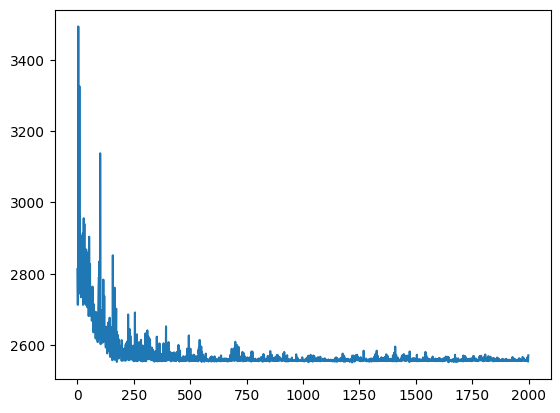

In [21]:
def run_svi_inference(
    model,
    n_steps=500,
    verbose=True,
    lr=0.03,
    vi_family=AutoMultivariateNormal,
    guide=None,
    **model_kwargs,
):
    losses = []
    if guide is None:
        guide = vi_family(model, init_loc_fn=init_to_mean)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        losses.append(loss.item())
        adam.step()
        if (step % 100 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))

    plt.plot(losses)

    return guide

pyro.clear_param_store()

print(y_true.shape, predictor.shape, init.shape)
guide = run_svi_inference(ar1_model, n_steps=2000, lr=0.03, 
                          vi_family= AutoMultivariateNormal,
                          outcome_obs = y_intermediate, predictor_obs = predictor, 
                            initial_obs = init, no_series = n_series)


In [23]:
predictive = pyro.infer.Predictive(ar1_model, guide=guide, num_samples = n_samples)
samples = predictive(initial_obs=init, predictor_obs = predictor,  T = T)

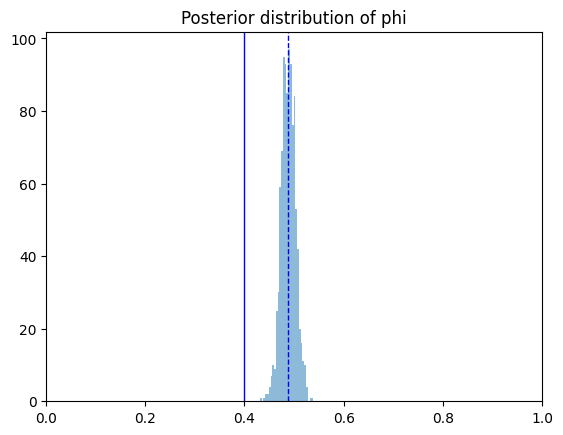

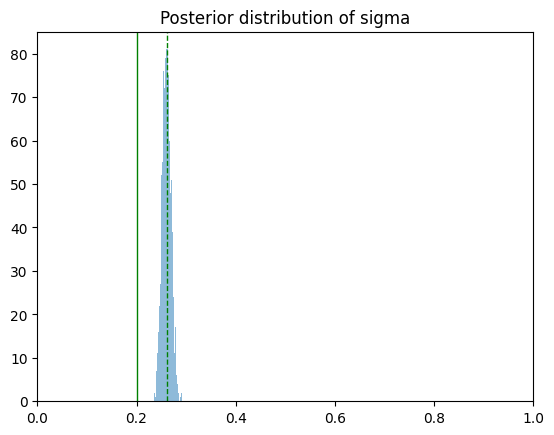

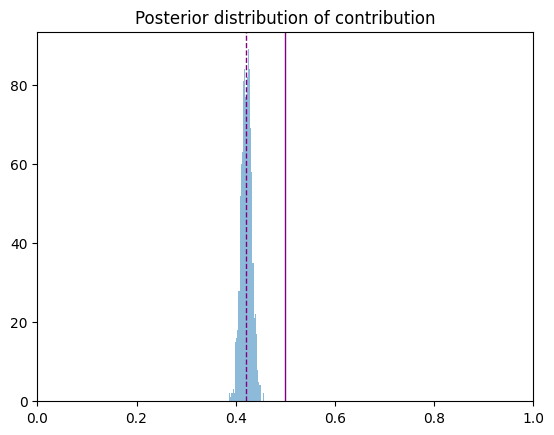

In [24]:
phi, sigma, contribution = samples["phi"].flatten(), samples["sigma"].flatten(), samples["contribution"].flatten()
phi, sigma = samples["phi"].flatten(), samples["sigma"].flatten()#, samples["contribution"].flatten()
phi_color = 'blue'
sigma_color = 'green'
contribution_color = 'purple'

sites = [phi, sigma, contribution]
names = ['phi', 'sigma', 'contribution']
colors = [phi_color, sigma_color, contribution_color]

for i in range(len(sites)):
    plt.hist(sites[i].numpy(), bins=30, alpha=0.5)
    plt.axvline(sites[i].mean().item(), color=colors[i], linestyle='dashed', linewidth=1, label=f'mean {names[i]}')
    plt.axvline(eval(f'true_{names[i]}'), color=colors[i], linewidth=1, label=f'true {names[i]}')
    plt.title(f"Posterior distribution of {names[i]}")
    plt.xlim(0, 1)
    plt.show()

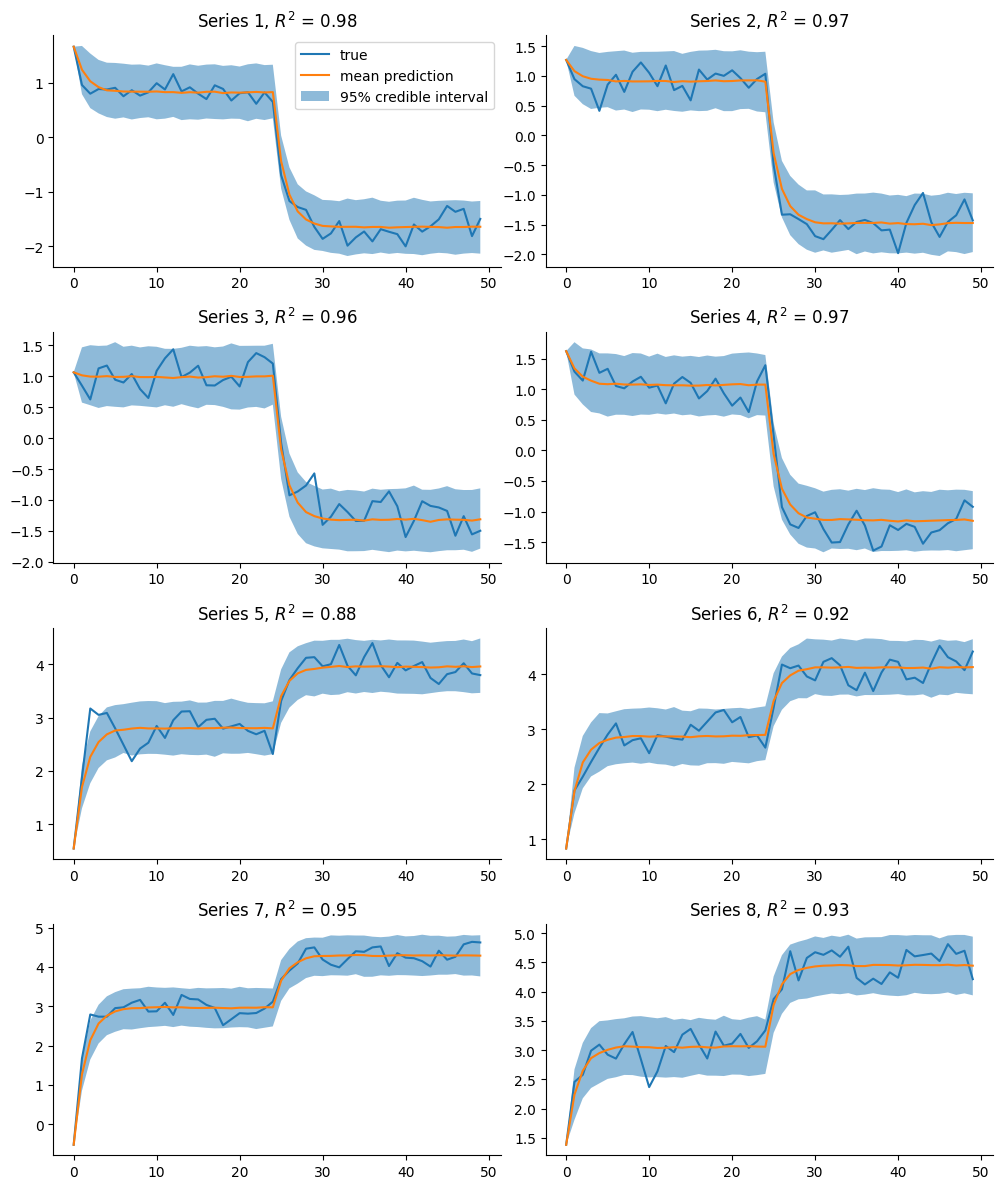

In [25]:

n_rows = math.ceil(n_series / 2)

fig, axs = plt.subplots(n_rows, 2, figsize=(10, n_rows * 3))

for series in range(n_series):

    ax = axs[series // 2, series % 2] if n_rows > 1 else axs[series % 2]
    
    ax.plot(y_true[series, :].detach().numpy(), label="true")
    mean_pred = samples['y_stacked'][...,series,:].mean(dim = -4).squeeze()
    low_pred = samples['y_stacked'][...,series,:].quantile(0.05, dim=-4).squeeze()
    high_pred = samples['y_stacked'][...,series,:].quantile(0.95, dim=-4).squeeze()

    overall_mean = y_true[series,:].mean()
    null_residuals = y_true[series,:] - overall_mean
    model_residuals = y_true[series,:] - mean_pred
    # r^2 
    r2 = 1 - (model_residuals.var() / null_residuals.var())


    ax.plot(mean_pred.detach().numpy(), label="mean prediction")

    ax.fill_between(range(T), low_pred.detach().numpy(),
                     high_pred.detach().numpy(), alpha=0.5, label="95% credible interval")


    ax.set_title(f"Series {series + 1}, $R^2$ = {r2:.2f}")

    if series == 0:
        ax.legend()
    
sns.despine()
plt.tight_layout()
plt.show()  
